## tensorflow tutorials メモ

tensorflowが2.0になってチュートリアルも新しくなりました。勉強がてら、すべてのチュートリアルを自分の環境で行ってみたいと思います。コードはほぼチュートリアルのコピーです。その中で気づいた部分や、注意すべき部分がこの記事の付加価値です。

今回は単語の埋め込み（分散表現の学習）です。リンクこちらです。

- https://www.tensorflow.org/tutorials/text/word_embeddings?hl=ja

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G6020


In [2]:
!python -V

Python 3.7.3


In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()


print('tf version     : ', tf.__version__)
print('keras version  : ', keras.__version__)
print('numpy version  : ',np.__version__)
print('pandas version : ',pd.__version__)
print('matlib version : ',matplotlib.__version__)

tf version     :  2.4.0
keras version  :  2.4.0
numpy version  :  1.19.4
pandas version :  1.0.3
matlib version :  3.0.3


## 単語の埋め込み(Word embeddings)

Embddingレイヤーの作成。埋め込みの重みはランダムに初期化。

In [8]:
embedding_layer = layers.Embedding(1000, 5)

In [26]:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

array([[-0.00446051,  0.01168355, -0.04535358,  0.03630742, -0.03531986],
       [-0.01487941, -0.03256115, -0.00449966, -0.01101733, -0.0280388 ],
       [-0.0031317 , -0.02346374,  0.01573559, -0.03014935,  0.01651401]],
      dtype=float32)

テキストやシーケンスの問題では、入力として`(samples, sequence_lenght)`の二次元整数テンソルとなる。シーケンスのバッチを入力すると、Embeddingレイヤーは`shape=(samples, sequence_length, embedding_dimensionality)`の三次元のFloaｔテンソルを返す。

In [10]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

## 埋め込みを最初から学習する

IMDBの映画レビューから感情分析器を作成する。tfdsからデータをロードする。

In [31]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

エンコーダー(tfds.features.text.SubwordTextEncoder)を取得し、どのような単語が含まれているか見る。

In [32]:
encoder = info.features['text'].encoder

In [33]:
print(encoder.subwords[:20])

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_']


映画のレビューは長さが異なっている。padded_batchを用いてレビューの長さを標準化する。tf2.2からpadded_shapesは必須ではなくなったようです。デフォルトで自動で最も長い文章に合わせてパディングされるようです。

In [13]:
train_data

<DatasetV1Adapter shapes: ((None,), ()), types: (tf.int64, tf.int64)>

パディングして、データをバッチ化します。

In [14]:
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=([None],[]))

2.2移行はこれで良さそうです。

In [15]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

In [16]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[ 156, 5053,  113, ...,    0,    0,    0],
       [ 968,   47, 3142, ...,    0,    0,    0],
       [  69,   57,   93, ...,    0,    0,    0],
       ...,
       [  12,  284,   14, ...,    0,    0,    0],
       [  62,  378,   80, ...,    0,    0,    0],
       [  19, 2373,   11, ...,    0,    0,    0]])

大きさを見てみます。

In [37]:
train_batch.numpy().shape

(10, 1085)

## 単純なモデルの構築

- 整数エンコードされた語彙を受け取り、埋め込みベクトルを返す。その結果次元は `(batch, sequence, embedding)`となる。
- GlobalAveragePooling1Dはそれぞれのサンプルについて、固定長の出力ベクトルを返す
- 16層の全結合隠れ層

In [17]:
embedding_dim = 16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


## モデルのコンパイル

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20, verbose=0)

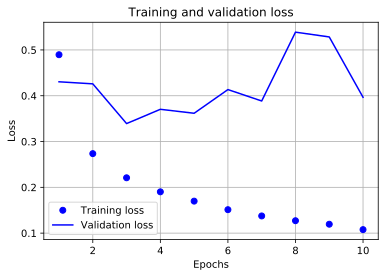

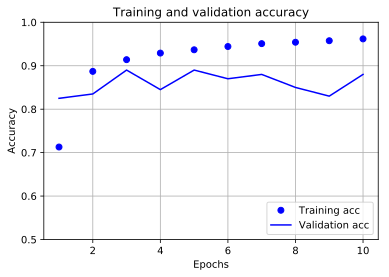

In [24]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.grid()
plt.show()

## 学習した埋め込みの取得

訓練によって、学習され行列を取得します。shapeが`(vocab_size, embedding_dim)`になります。

In [20]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


## ファイルへ出力

In [21]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # 0 はパディングのためスキップ
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [22]:
try:
  from google.colab import files
except ImportError:
   pass
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')